In [4]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [ ]:
dataDir='C:\\Users\\ABHINAV\\Downloads\\eye\\dataset'

In [ ]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

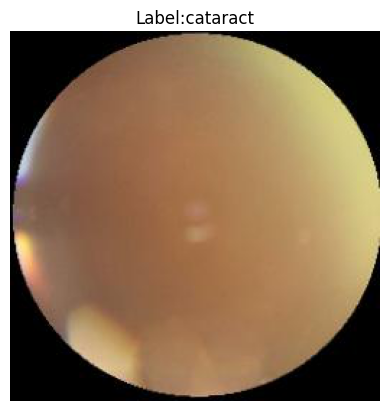

In [ ]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [ ]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'
    

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])
          
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [ ]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3372 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


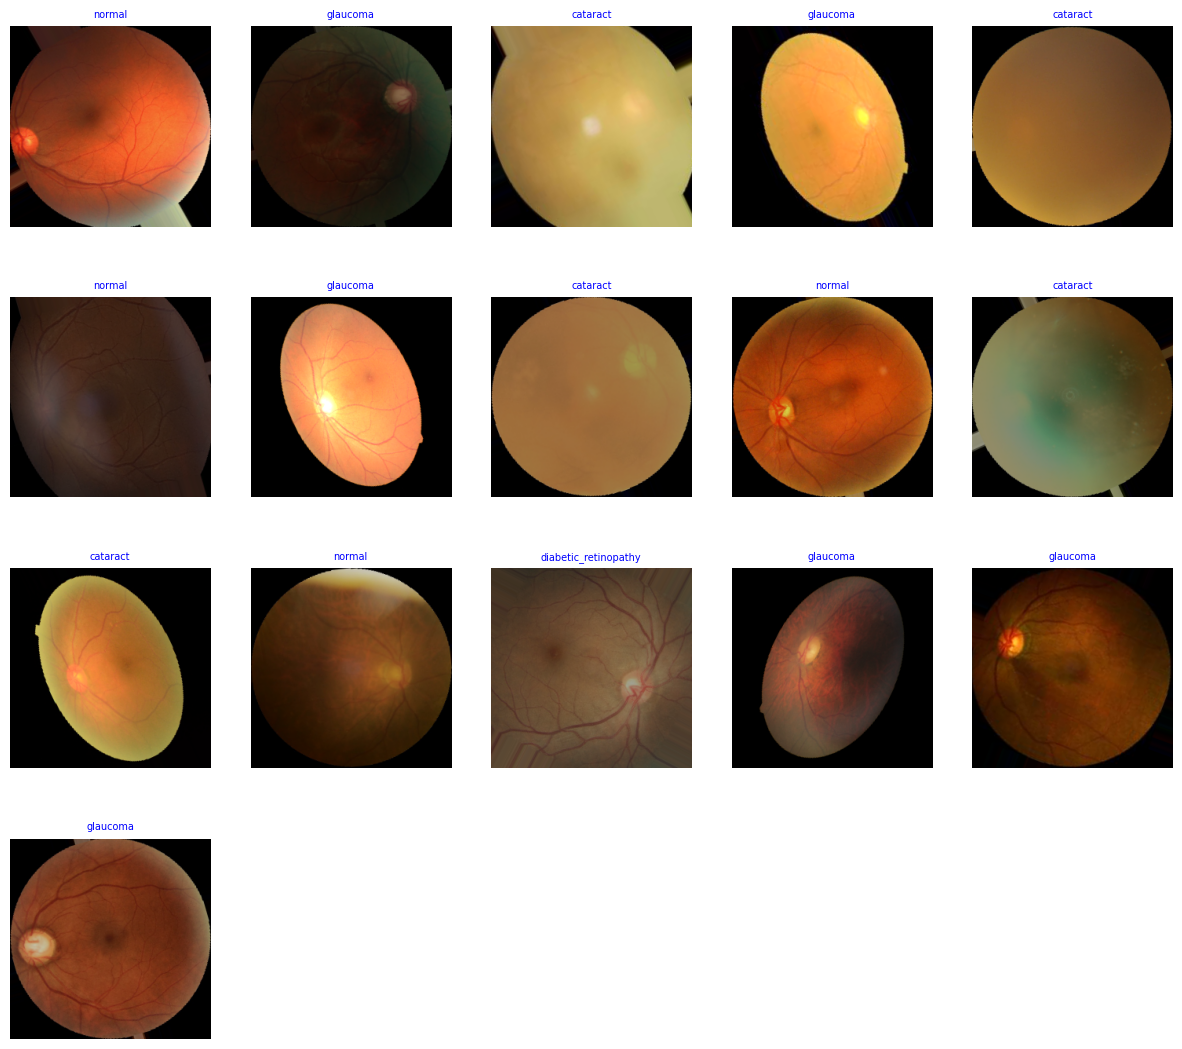

In [ ]:
def show_images(gen):
      
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)   
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_augmented,
    epochs=15, 
    validation_data=valid_augmented,
    )

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.6494 - loss: 4.2697 - val_accuracy: 0.6967 - val_loss: 1.1228
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.7470 - loss: 0.8915 - val_accuracy: 0.7464 - val_loss: 0.8142
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.7497 - loss: 0.8043 - val_accuracy: 0.6374 - val_loss: 1.0775
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.7559 - loss: 0.7632 - val_accuracy: 0.6256 - val_loss: 0.9404
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7538 - loss: 0.7491 - val_accuracy: 0.7251 - val_loss: 0.8115
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.7691 - loss: 0.7046 - val_accuracy: 0.7251 - val_loss: 0.8132
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7633 - loss: 0.7241 - val_accuracy: 0.7109 - val_loss: 0.8925
Epoch 8/15
119/211 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.7646 - loss: 0.7293

In [ ]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_augmented)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# import os

# # Path to your image (change this to your actual file)
# img_path = "C:\\Users\\ABHINAV\\Downloads\\eye\\dataset\\diabetic_retinopathy\\119_left.jpeg"

# # Load image with target size
# img = image.load_img(img_path, target_size=(256, 256))

# # Convert to array
# img_array = image.img_to_array(img)

# # Expand dims to add batch size (1, 256, 256, 3)
# img_array = np.expand_dims(img_array, axis=0)

# # Normalize
# img_array = img_array / 255.0

# # Predict
# prediction = model.predict(img_array)

# # Decode the prediction
# predicted_index = np.argmax(prediction, axis=1)[0]
# class_indices = train_augmented.class_indices
# labels = dict((v, k) for k, v in class_indices.items())
# predicted_label = labels[predicted_index]

# print(f"Predicted label: {predicted_label}")
print(train_augmented.class_indices)
print(labels)


In [ ]:
train_data['labels'].value_counts()

In [ ]:
loss, accuracy = model.evaluate(test_augmented)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")